## NLP应用-情感分析模型训练环节-双向RNN

In [1]:
# 双向RNN和GLOVE结合使用
import torch
from torch import nn
import dltools

batch_size = 64
train_iter, test_iter, vocab = dltools.load_data_imdb(batch_size)

In [2]:
# 使用循环神经网络表示单个文本
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经网络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # inputs的形状是（批量大小，时间步数）
        # 因为长短期记忆网络要求其输入的第一个维度是时间维，
        # 所以在获得词元表示之前，输入会被转置。
        # 输出形状为（时间步数，批量大小，词向量维度）
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态，
        # outputs的形状是（时间步数，批量大小，2*隐藏单元数）
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态，作为全连接层的输入，
        # 其形状为（批量大小，4*隐藏单元数）
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [3]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = dltools.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [4]:
# 加载预训练词向量
glove_embedding = dltools.TokenEmbedding('glove.6b.100d')

In [5]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

In [6]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.285, train acc 0.881, test acc 0.852
11.7 examples/sec on [device(type='cpu')]


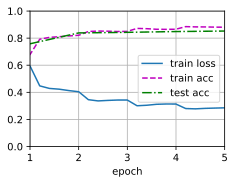

In [8]:
# 训练和模型评估
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
dltools.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

In [36]:
# 预测环节
def predict_sentiment(net, vocab, sequence):
    """预测文本序列的情感"""
    sequence = torch.tensor(vocab[sequence.split()], device=dltools.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [37]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [40]:
predict_sentiment(net, vocab, 'this movie is worse') 

'negative'